In [2]:
from importlib import reload
import sys
import os
sys.path.append(os.path.abspath('../'))
import util
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

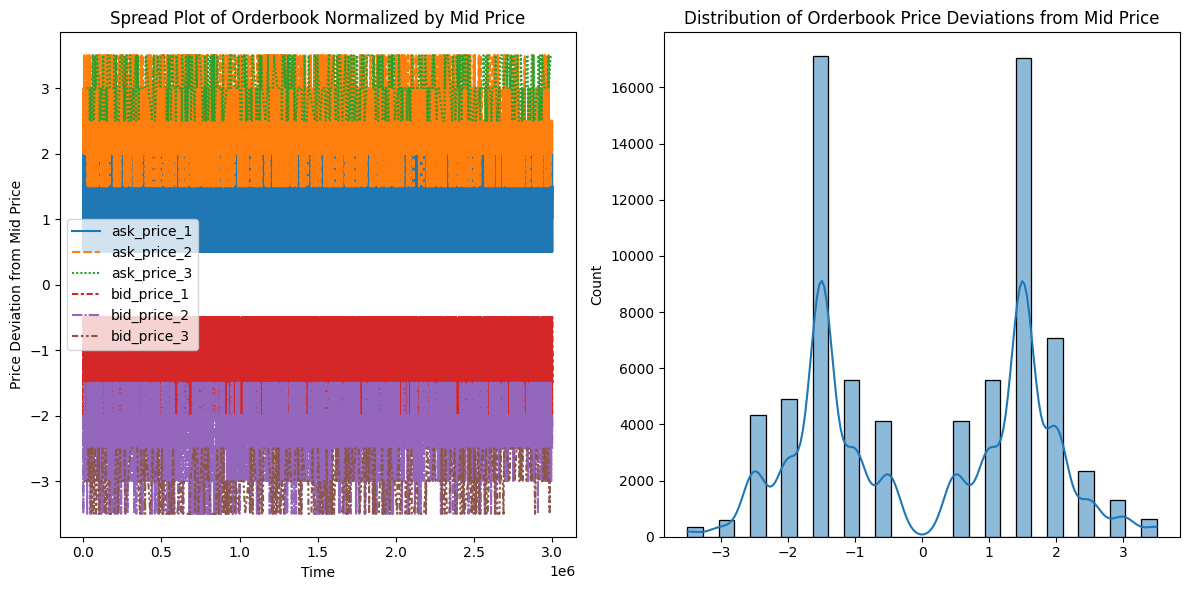

In [3]:
reload(util)
dm2p = util.load_all_price_data(1)
util.spread_plot(dm2p,'SQUID_INK')

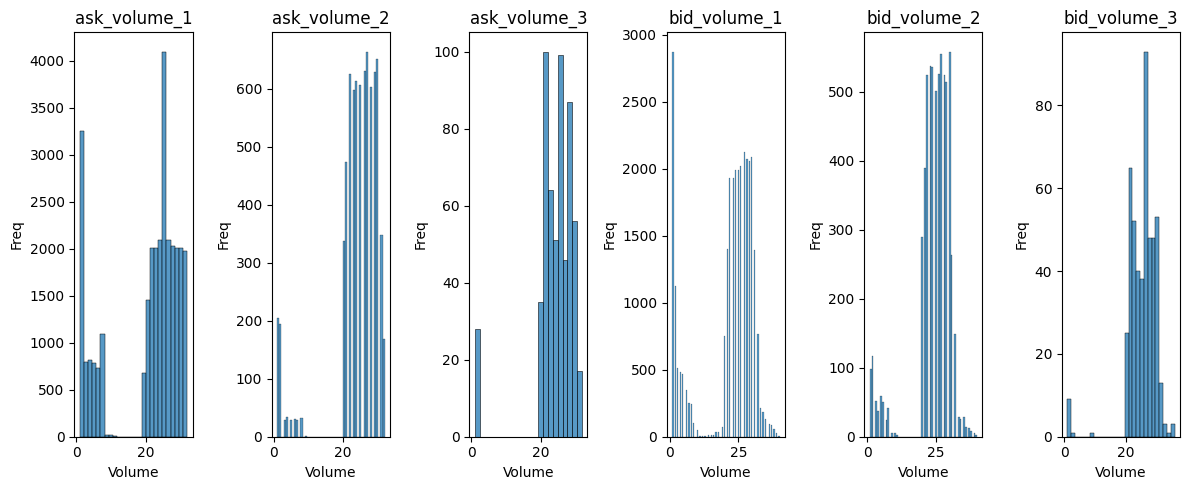

In [4]:
reload(util)
util.volume_plot(dm2p,'SQUID_INK')

In [5]:
reload(util)
squid_vwap = util.get_vwap(dm2p,'SQUID_INK')
kelp_vwap = util.get_vwap(dm2p,'KELP')

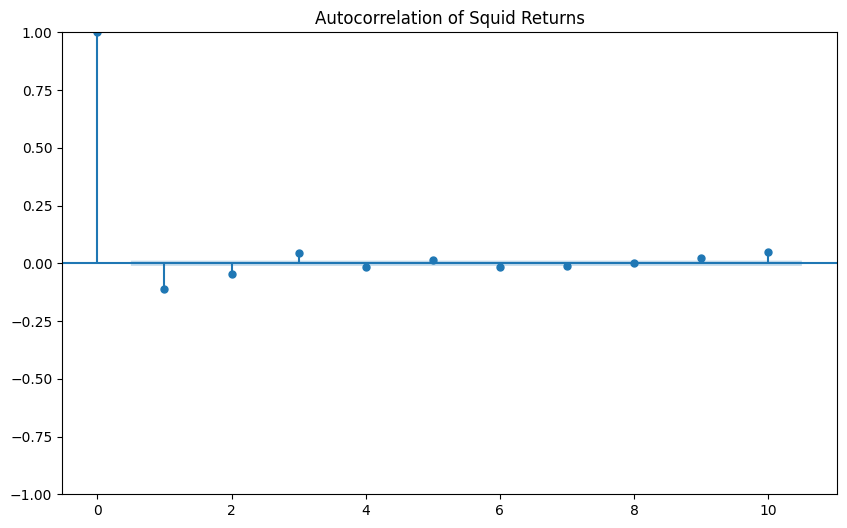

In [6]:
#autocorr plot
import statsmodels.api as sm

# Plot the autocorrelation of the returns
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_acf(np.log(squid_vwap).diff().dropna(), lags=10, ax=ax)
plt.title('Autocorrelation of Squid Returns')
plt.show()

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

# Set a random seed for reproducibility
np.random.seed(42)

# Generate synthetic data for demonstration
n = 100
# Series X: random noise
x = np.log(kelp_vwap).diff()
# Series Y: influenced by a lagged version of X plus some noise
# Here, y_t = 0.5 * x_(t-1) + noise
y = np.log(squid_vwap).diff()

# Create a DataFrame and drop the initial NaN value to align the series
df = pd.DataFrame({'y': y, 'x': x}).dropna()

# Perform the Granger causality test
# Here, we test if series 'x' helps predict series 'y'.
# The first column in the DataFrame should be the target variable (y in this case).
maxlag = 10  # You can choose the maximum number of lags to test
test_result = grangercausalitytests(df[['y', 'x']], maxlag=maxlag)

# The test prints detailed results for each lag.
# You can check the p-values for each lag to assess significance.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4084  , p=0.2353  , df_denom=29995, df_num=1
ssr based chi2 test:   chi2=1.4085  , p=0.2353  , df=1
likelihood ratio test: chi2=1.4085  , p=0.2353  , df=1
parameter F test:         F=1.4084  , p=0.2353  , df_denom=29995, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9494  , p=0.3870  , df_denom=29992, df_num=2
ssr based chi2 test:   chi2=1.8990  , p=0.3869  , df=2
likelihood ratio test: chi2=1.8990  , p=0.3869  , df=2
parameter F test:         F=0.9494  , p=0.3870  , df_denom=29992, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7648  , p=0.5136  , df_denom=29989, df_num=3
ssr based chi2 test:   chi2=2.2950  , p=0.5135  , df=3
likelihood ratio test: chi2=2.2949  , p=0.5135  , df=3
parameter F test:         F=0.7648  , p=0.5136  , df_denom=29989, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6118  

In [8]:
in_sample_squid = squid_vwap.iloc[:20000]

<Axes: xlabel='timestamp'>

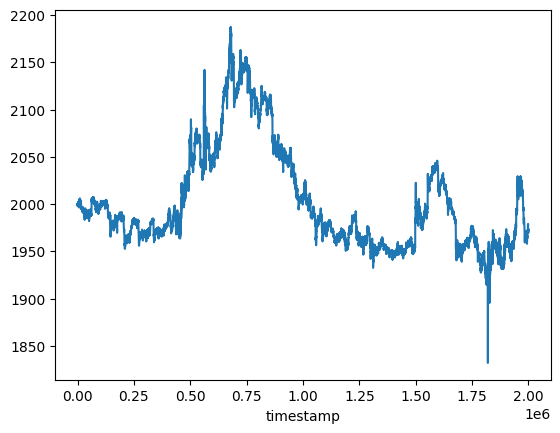

In [9]:
sns.lineplot(in_sample_squid)

<Axes: xlabel='timestamp'>

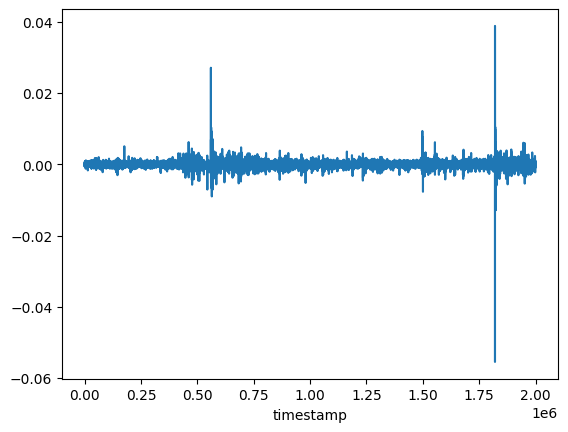

In [10]:
np.log(in_sample_squid).diff().dropna().plot()

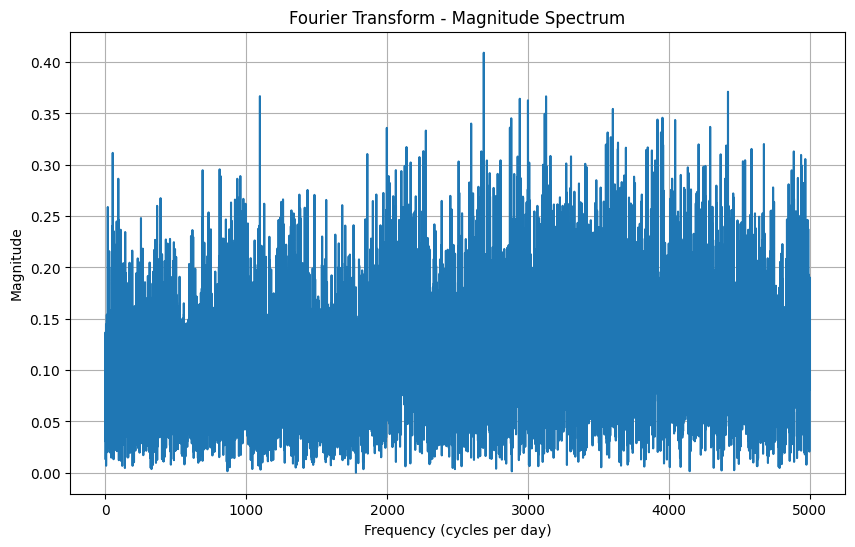

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fourier_transform(signal, sampling_rate):
    """
    Computes the Fourier Transform of a signal and plots its magnitude spectrum.
    
    Parameters:
        signal (numpy.array): The time-domain signal.
        sampling_rate (float): Sampling rate of the signal.
            - If your data is in days, this would be in samples per day.
            - If in seconds, this would be in Hz.
    """
    n = len(signal)
    
    fft_vals = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(n, d=1/sampling_rate)
    
    pos_mask = fft_freq >= 0
    fft_freq = fft_freq[pos_mask]
    fft_magnitude = np.abs(fft_vals)[pos_mask]
    
    plt.figure(figsize=(10, 6))
    plt.plot(fft_freq, fft_magnitude)
    plt.title('Fourier Transform - Magnitude Spectrum')
    plt.xlabel('Frequency (cycles per day)' if sampling_rate > 1 else 'Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()


log_returns = np.log(in_sample_squid).diff().dropna().values

plot_fourier_transform(log_returns, sampling_rate=10000)




In [13]:
import numpy as np
import math
from scipy.stats import norm

def runs_test(sequence):
    """
    Performs the runs test (Wald–Wolfowitz runs test) on a sequence of numbers.
    The sequence is converted to a binary series using the median as the threshold.
    
    Parameters:
        sequence (list or numpy array): The input sequence of observations.
        
    Returns:
        A dictionary containing:
            - runs: observed number of runs
            - expected_runs: expected number of runs under the null hypothesis
            - variance_runs: variance of the number of runs
            - z: z-score for the test statistic
            - p_value: two-tailed p-value
    """
    # Convert sequence to a numpy array for convenience
    sequence = np.asarray(sequence)

    # Determine the median and convert observations to binary values:
    # 1 if value is greater than or equal to the median, else 0
    median_val = np.median(sequence)
    binary_sequence = [1 if x >= median_val else 0 for x in sequence]

    # Count the number of 1's and 0's
    n1 = sum(binary_sequence)
    n2 = len(binary_sequence) - n1

    # Count the number of runs: a run starts when the current binary differs from the previous.
    runs = 1  # there is at least one run
    for i in range(1, len(binary_sequence)):
        if binary_sequence[i] != binary_sequence[i - 1]:
            runs += 1

    # Calculate the expected number of runs and its variance under the null hypothesis.
    expected_runs = ((2 * n1 * n2) / (n1 + n2)) + 1
    variance_runs = (2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / (((n1 + n2) ** 2) * (n1 + n2 - 1))

    # Compute the z-score (using no continuity correction for simplicity).
    z = (runs - expected_runs) / math.sqrt(variance_runs)
    
    # Calculate the two-tailed p-value from the standard normal distribution.
    p_value = 2 * (1 - norm.cdf(abs(z)))

    return {
        "runs": runs,
        "expected_runs": expected_runs,
        "variance_runs": variance_runs,
        "z": z,
        "p_value": p_value
    }
runs_test(log_returns)

{'runs': 10625,
 'expected_runs': 9956.739586979349,
 'variance_runs': 4955.835332741312,
 'z': 9.492646338621709,
 'p_value': 0.0}